In [1]:
!unzip ita-eng.zip

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [2]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import os
import re
path=os.getcwd()+'/ita.txt'
# To read the file
import io
import numpy as np
# For normalizing data
import unicodedata
# Tensorflow libraries
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
# Metric that can tell the strength of relation between two sentences
import nltk.translate.bleu_score as bleu

In [3]:
# Converting into unicode --http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Function to convert into lower case, remove punctuation.
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

In [4]:
# To open the file and read line by line

lines=io.open('/content/ita.txt',encoding='UTF-8').read().split('\n')

In [5]:
lines[9010]

"I'm so drunk.\tSono così ubriaca.\tCC-BY 2.0 (France) Attribution: tatoeba.org #3724445 (CM) & #3950183 (Guybrush88)"

In [6]:

def makedata(num_examples):
    '''
      The function will return eng - Ita sentences pairs
    '''
    ita_data=[]
    eng_data=[]
    eng_in=[]
    eng_out=[]
    for i in range(num_examples):
        
        eng,ita,_=lines[i].split('\t')
        
        # lines = I'm so drunk.\tSono così ubriaca.	CC-BY 2.0 (France) Attribution: tatoeba.org #3724445 (CM) & #3950183 (Guybrush88)
        # eng = I'm so drunk.
        # ita = Sono così ubriaca.

        eng=normalize_string(eng)
        ita=normalize_string(ita)

        # For decoder input we will add start tag
        eng_in_='<start> '+eng
        # For decoder output we will add end tag
        eng_out_= eng + ' <end>'
        eng= '<start> ' +eng + ' <end>'
        ita_data.append(ita)
        eng_in.append(eng_in_)
        eng_out.append(eng_out_)
        eng_data.append(eng)
    
    return ita_data,eng_in,eng_out,eng_data

In [7]:
len(lines)

352041

In [8]:
num_examples=20000
ita_data,eng_in,eng_out,eng_data=makedata(num_examples)

In [9]:
print('Encoder  input:',ita_data[-1][:-1])
print('Decoder  input:',eng_in[-1][:-1])
print('Decoder output:', eng_in[-1][8:-1]+'<end>')

Encoder  input: io sono un pacifista 
Decoder  input: <start> i m a pacifist 
Decoder output: i m a pacifist <end>


In [10]:
# Converting the text data to integer words

# Declare a tokenizer
# Fit the tokenizer on Italy language pairs
# inp_lan will have an integer represented for each word
# Pad sequences (By default it will pad zeros till the max length of the ita_data)
# Here inp_lan is the encoder input data.

ita_tokenizer=Tokenizer(filters='')
ita_tokenizer.fit_on_texts(ita_data)
inp_lan=ita_tokenizer.texts_to_sequences(ita_data)
inp_lan=pad_sequences(inp_lan,padding='post')

In [11]:
# Declare the tokenizer for english words
eng_tokenizer=Tokenizer(filters='')
# we are fitting on eng_data not on eng_in or eng_out as it has both <start> and <end> tags
eng_tokenizer.fit_on_texts(eng_data)

# Decoder input data
tar_lan_in=eng_tokenizer.texts_to_sequences(eng_in)
tar_lan_in=pad_sequences(tar_lan_in,padding='post')

# Decoder output data
tar_lan_out=eng_tokenizer.texts_to_sequences(eng_out)
tar_lan_out=pad_sequences(tar_lan_out,padding='post')


In [12]:
print('Encoder input Text data:',ita_data[9010])
print('Integer representation: ',inp_lan[9010])
print('-'*70)
print('Decoder input Text data:',eng_in[9010])
print('Integer representation: ',tar_lan_in[9010])
print('-'*70)
print('Decoder output Text data:',eng_out[9010])
print('Integer representation: ',tar_lan_out[9010])


Encoder input Text data: sono cosi ubriaca .
Integer representation:  [  2  52 291   1   0   0   0   0   0]
----------------------------------------------------------------------
Decoder input Text data: <start> i m so drunk .
Integer representation:  [ 1  4  8 67 89  3  0]
----------------------------------------------------------------------
Decoder output Text data: i m so drunk . <end>
Integer representation:  [ 4  8 67 89  3  2  0]


In [13]:
# Total number of unique words in Italian sentence 
ita_vocab_size=len(ita_tokenizer.word_index)+1
print('vocab size of italian words are:',ita_vocab_size)
# Total number of unique words in english sentence
eng_vocab_size=len(eng_tokenizer.word_index)+1
print('vocab size of english words are:',eng_vocab_size)

vocab size of italian words are: 5604
vocab size of english words are: 2237


In [14]:
# Max length of input_sequence, max_length of target sequence 
inp_seq_length=inp_lan[0].shape[0]
tar_seq_length=tar_lan_in[0].shape[0]

#Now we will seperate the words and its index of english words
eng_index_word={}
eng_word_index={}
for key,value in eng_tokenizer.word_index.items():
  eng_index_word[value]=key 
  eng_word_index[key]=value

In [15]:
print('shape of input lang is         :',inp_lan.shape)
print('shape of target lang input is  :',tar_lan_in.shape)
print('shape of target lang output is :',tar_lan_out.shape)

shape of input lang is         : (20000, 9)
shape of target lang input is  : (20000, 7)
shape of target lang output is : (20000, 7)


In [16]:
#Encoder input shape will be (Batch_size,inp_seq_length) --
input_encoder=Input(shape=(inp_seq_length,))

# Encoder LSTM needs the input to be 3 dim. One easy way to add a dimension to this integer sequences is to add a Embedding layer.

# input_encoder is passed to the embedding layer.  
encoder_embedding=Embedding(input_dim=ita_vocab_size,output_dim=128)(input_encoder)
# encoder_embedding shape is (Batch_size,inp_seq_length,output_dim) --
# Trainable paramters is ita_vocab_size * 128. 
# Each integer in the input_encoder is converted to 128 dimensional vector


encoder_lstm=LSTM(256,return_state=True)(encoder_embedding)
# Encoder_LSTM will return three arrays 
# 1. hidden_state/output of the last time step (None,256), 
# 2. hidden_state/ output of the last time step(None,256), 
# 2. cell_state of the last time step (None,256)


In [17]:
encoder_states=encoder_lstm[1:]
# Select the last two hidden states.

In [18]:
# Decoder input, we will keep the shape (None). Note: If none it can accept any size of data in dimension
# The reason we are not fixing the input_decoder to max_length is during 
# inference we will be sending only one input at a time step and predict. 

input_decoder = Input(shape=(None,))
# input_decoder shape is (None,None)

decoder_embedding_layer=Embedding(input_dim=eng_vocab_size,output_dim=128)
decoder_embedding_output=decoder_embedding_layer(input_decoder)
# decoder_embedding_layer - (None,None,128) 

decoder_lstm=LSTM(256,return_sequences=True,return_state=True)
decoder_output,_,_=decoder_lstm(decoder_embedding_output,initial_state=encoder_states)
# decoder_lstm will return three outputs
# 1. All the hiddenstate/output at each time step (None,None,256)
# 2. hiddenstate/output at last time step (None,256)
# 3. Cell state at last time step (None,256)


In [19]:
# Apply dense layer(units=eng_vocab_size) at every time step of the decoder_output
decoder_dense=TimeDistributed( Dense(eng_vocab_size,activation='softmax'))
dense_output= decoder_dense(decoder_output)
# dense_output shape (None,none, eng_vocab_size)


In [20]:
# Our model has two inputs, one to the encoder and other to the decoder. 
# outputs - Dense layer output
model=Model([input_encoder,input_decoder],dense_output)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 9, 128)       717312      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    286336      input_2[0][0]                    
______________________________________________________________________________________________

In [22]:
# if input_decoder shape is (None,max_length)
# Dense output shape is (None,max_length,eng_vocab_size), decoder_output (None,max_length)
# Target data is just integers, while predicted data is a softmax output
# we apply sparse_categorical_crossentropy instead of categorical_crossentropy
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# Train the model
model.fit([inp_lan, tar_lan_in], tar_lan_out,
          batch_size=64,
          epochs=20,
          validation_split=0.2)

Epoch 1/20
250/250 [==============================] - 14s 25ms/step - loss: 2.4484 - val_loss: 2.5315
Epoch 2/20
250/250 [==============================] - 5s 21ms/step - loss: 1.7574 - val_loss: 2.2504
Epoch 3/20
250/250 [==============================] - 5s 20ms/step - loss: 1.4697 - val_loss: 2.0899
Epoch 4/20
250/250 [==============================] - 5s 20ms/step - loss: 1.2962 - val_loss: 2.0077
Epoch 5/20
250/250 [==============================] - 5s 20ms/step - loss: 1.1682 - val_loss: 1.9864
Epoch 6/20
250/250 [==============================] - 5s 20ms/step - loss: 1.0705 - val_loss: 1.9508
Epoch 7/20
250/250 [==============================] - 5s 20ms/step - loss: 0.9827 - val_loss: 1.9563
Epoch 8/20
250/250 [==============================] - 5s 20ms/step - loss: 0.9085 - val_loss: 1.9252
Epoch 9/20
250/250 [==============================] - 5s 20ms/step - loss: 0.8467 - val_loss: 1.9470
Epoch 10/20
250/250 [==============================] - 5s 20ms/step - loss: 0.7901 - val_l

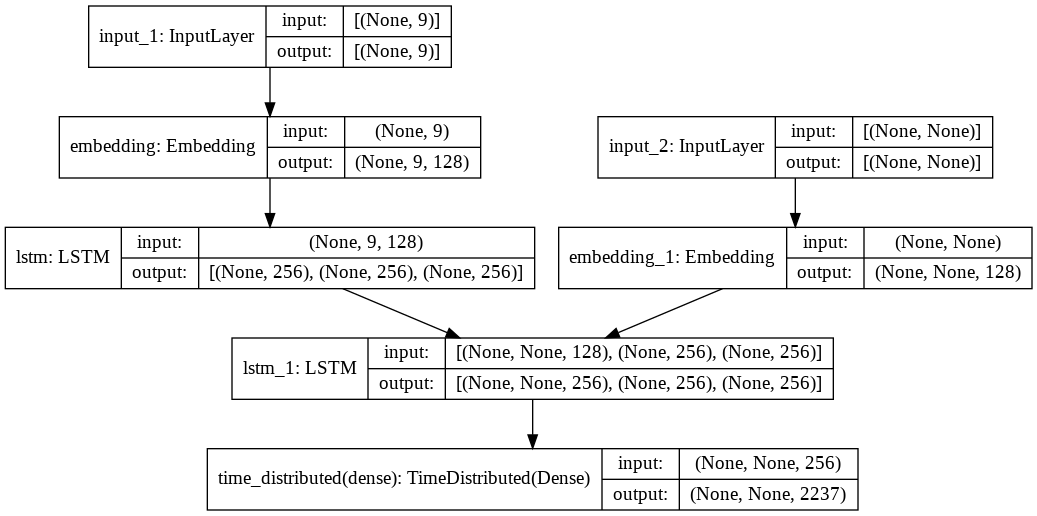

In [23]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
#Encoder model for inference
encoder_model=Model(input_encoder,encoder_lstm)
# encoder_model takes a integer sequence of Italian language as input and returns hidden_state and cell_state

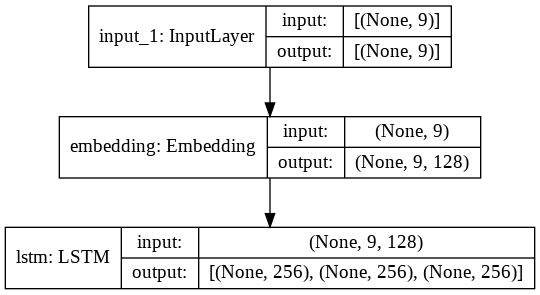

In [27]:
tf.keras.utils.plot_model(encoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
#encoder_model.summary(line_length=200)
print(encoder_model.layers[1].weights[0][0][:10])
print(model.layers[2].weights[0][0][:10])

tf.Tensor(
[-0.02162567 -0.04781285 -0.00901964  0.00027226  0.00064205 -0.02776079
 -0.08027325  0.03244826  0.08223557  0.01386485], shape=(10,), dtype=float32)
tf.Tensor(
[-0.02162567 -0.04781285 -0.00901964  0.00027226  0.00064205 -0.02776079
 -0.08027325  0.03244826  0.08223557  0.01386485], shape=(10,), dtype=float32)


In [28]:
# Decoder states - shape is LSTM_Size
decoder_state_h=Input(shape=(256))
decoder_state_c=Input(shape=(256))
decoder_state_inputs=[decoder_state_h,decoder_state_c]

In [29]:
input_decoder.shape

TensorShape([None, None])

In [30]:
# Input to decoder is send to embedding layer
decoder_embedding_output=decoder_embedding_layer(input_decoder)

# Get the decoder outputs when a particular input and initial_state is given
decoder_outputs,state_h,state_c=decoder_lstm(decoder_embedding_output,initial_state=decoder_state_inputs)
decoder_states=[state_h,state_c]
# Send the decoder outputs to the dense layer to get the predicted word
decoder_outputs=decoder_dense(decoder_outputs)


In [31]:
# decoder model takes two inputs 1. Decoder input 2. Decoder initial states
# returns two outputs 1. Decoder outputs 2. decoder states(hidden_state and cell state)
decoder_model=Model([input_decoder]+decoder_state_inputs,[decoder_outputs]+decoder_states)

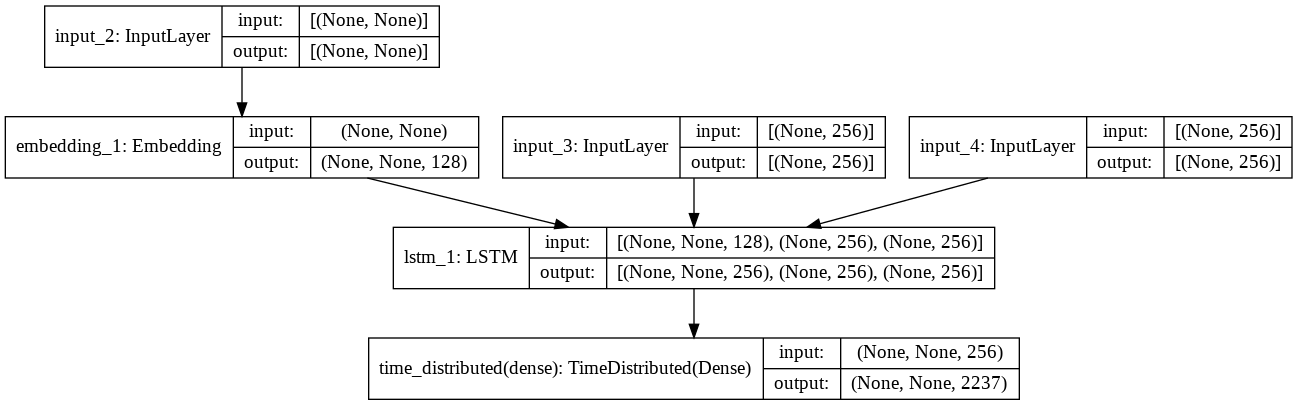

In [32]:
tf.keras.utils.plot_model(decoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    286336      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [35]:
def inference(seq):
  '''
    Function that takes Italian sequence and returns English sequence
  '''
  # Input the sequence to encoder_model and get the final timestep encoder_states(Hidden and cell state)
  seq=seq.reshape(-1,9)
  encoder_state_value=encoder_model.predict(seq)
  encoder_state_value=encoder_state_value[1:]
  # encoder_state_value[0] -- hidden_state -- shape (None,256)
  # encoder_state_value[1] -- cell_state -- shape (None,256)

  # Target word
  target_word=np.zeros((1,1))
  # <start>:1 , <end>:2 -- 
  target_word[0,0]=1
  
  stop_condition=False
  sent=''
  k=0
  while not stop_condition:

      # We are giving a target_word which represents <start> and encoder_states to the decoder_model
      output,state_h,state_c=decoder_model.predict([target_word]+encoder_state_value)
      # As the target word length is 1. We will only have one time step
      encoder_state_value=[state_h,state_c]
      # Output shape (1,eng_vocab_size). Find the word which the decoder predicted with max_probability
      output=np.argmax(output,-1)
      #print(output)
      # The output is a integer sequence, to get back the word. We use our lookup table reverse_dict
      sent=sent+' '+eng_index_word[int(output)]
      k+=1
      # If the max_length of the sequence is reached or the model predicted 2 (<end>) stop your model
      if k>5 or output==2:
        stop_condition=True
      target_word=output.reshape(1,1)
  
  return sent

In [36]:
from prettytable import PrettyTable
import random    
x = PrettyTable()
x.field_names = ["Input data", "Actual data", "Predicted data"]

for i in range(10):
  index=random.randint(1,10000)
  pred=inference(inp_lan[index])
  x.add_row([ita_data[index],eng_out[index],pred])
  # print('Input data is: ',ita_data[index])
  # print('Actual data is: ',eng_out[index])
  # print('Predicted data is:',pred)
print(x)

+-------------------------+----------------------+-----------------------+
|        Input data       |     Actual data      |     Predicted data    |
+-------------------------+----------------------+-----------------------+
|  tom si e accigliato .  | tom frowned . <end>  |   tom cursed . <end>  |
|     non gongolare .     | don t gloat . <end>  |   don t yell . <end>  |
|        e fredda .       |  it s cool . <end>   |    it s cool . <end>  |
| sono impegnata adesso . | i m busy now . <end> |  i m busy now . <end> |
| nessuno lo ha chiesto . | nobody asked . <end> |   no one ran . <end>  |
|   io sono perfettina .  | i m finicky . <end>  |   i m finicky . <end> |
|  vattene per piacere .  | please leave . <end> |  please leave . <end> |
|  sorrida per piacere .  | please smile . <end> |  please smile . <end> |
|       finiscila !       |  cut it out ! <end>  |   cut it out ! <end>  |
|     l ha calciata .     | he kicked it . <end> |  he kicked it . <end> |
+------------------------